Install rawpy package


In [1]:
!pip install rawpy 

     |████████████████████████████████| 1.6MB 4.7MB/s 


Import required libraries

In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import rawpy

Mount google drive to read and write images.

In [3]:
from google.colab import drive 
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Process the images using the rawpy packege as specified in the question. 
Store the images in a dictionary with keys as the exposure number.

In [0]:
processed_exposure = {}
for i in range(1,17):
  temp = rawpy.imread('/content/drive/My Drive/exposure'+str(i)+'.nef')
  rgb = temp.postprocess(gamma=(1,1),no_auto_bright=True,output_bps=16)
  rgb=cv2.resize(rgb,(int(rgb.shape[1]*0.5),int(rgb.shape[0]*0.5)))
  rgb = np.float32(rgb)/255
  #cv2.imwrite('/content/drive/My Drive/processed_exposure'+str(i)+'.tiff',rgb)
  processed_exposure[str(i)]=rgb



Define a weighting function.

In [0]:
def weight(pixel):
  if (pixel <=0.05 or pixel >0.95):
    return pixel
  return math.exp(-4*((pixel - 0.5)**2)/0.5**2)

Define the HDR function.

In [0]:
def HDR(img_arr):
  hdr = np.zeros(img_arr['1'].shape)

  for i in range (0,img_arr[str(1)].shape[0]-1):
    for j in range(0,img_arr[str(1)].shape[1]-1):
      temp1_r = 0
      temp1_g = 0
      temp1_b = 0
      temp2_r = 0
      temp2_g = 0
      temp2_b = 0
      for k in range (1,17):
        #Extract the same pixel from all the exposure images
        pixel_r = img_arr[str(k)][i][j][0]
        pixel_g = img_arr[str(k)][i][j][1]
        pixel_b = img_arr[str(k)][i][j][2]

        #weight each pixel depending on the insensity value
        w_r= weight(pixel_r)
        w_b= weight(pixel_b)
        w_g= weight(pixel_g)

        temp1_r += (w_r * pixel_r / (1/2048 * (2**k-1))) 
        temp1_g += (w_g * pixel_g / (1/2048 * (2**k-1)))
        temp1_b += (w_b * pixel_b / (1/2048 * (2**k-1)))

        temp2_r += w_r 
        temp2_g += w_g
        temp2_b += w_b
      
      #calculate the final value of the pixel
      hdr[i][j][0]= temp1_r/temp2_r
      hdr[i][j][1]= temp1_g/temp2_g
      hdr[i][j][2]= temp1_b/temp2_b
  
  return hdr




In [0]:
res = HDR(processed_exposure)

Show the HDR image

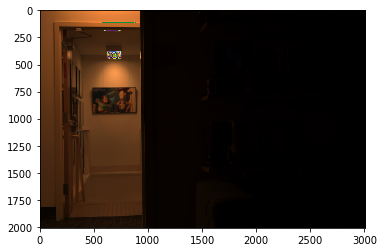

In [19]:
plt.imshow(res.astype('uint8'))

Define the photogrphic tone mapping function as given in the question.

In [0]:
def tonemap(hdr):
  temp = np.zeros(hdr.shape)
  for i in range(0,3):
    temp[:,:,i] = hdr[:,:,i]/(1+hdr[:,:,i])
    #print(temp[:,:,i])
  return temp 

Show the tone mapped image.

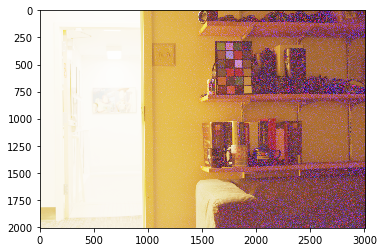

In [21]:
tonemapped = tonemap(res)
plt.imshow(tonemapped)

Using inbuilt tone mapping disply the HDR image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


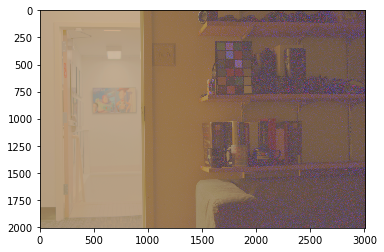

In [22]:
res= np.float32(res)
res = res*255
tonemap = cv2.createTonemapDrago(4.2)
result = tonemap.process(res)
plt.figure()
plt.imshow(result)